In [1]:
import os
import random

import gurobipy as gp
from gurobipy import GRB
import xlrd
import pandas as pd
from datetime import datetime, date
import matplotlib
from matplotlib import pyplot as plt
import networkx as nx
from network_setup import *
from data_setup import *
from EnergyCommunityModel import *

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
from CommunityMember import *

# buildings data
buildings_path = "C:\\Users\joche\FIM Kernkompetenzzentrum\Paper Agent-based Modeling - Dokumente\General\\04 ABM\\03_data\\tetraeder_solar\\20220815_0833_kreis_ingolstadt_buildings_export.shp"
roofs_path = "C:\\Users\joche\FIM Kernkompetenzzentrum\Paper Agent-based Modeling - Dokumente\General\\04 ABM\\03_data\\tetraeder_solar\\20220815_0833_kreis_ingolstadt_roofs_export.shp"
# manually curated input
custom_communities_path = 'C:\\Users\joche\FIM Kernkompetenzzentrum\Paper Agent-based Modeling - Dokumente\General\\04 ABM\\03_data\custom_communities'
optimization_parameter_path = 'C:\\Users\joche\FIM Kernkompetenzzentrum\Paper Agent-based Modeling - Dokumente\General\\04 ABM\\03_data\optimization_parameters\\2022 09 06 optimization_parameter.xlsx'
# time series data
residential_load_profile_path = "C:\\Users\joche\FIM Kernkompetenzzentrum\Paper Agent-based Modeling - Dokumente\General\\04 ABM\\03_data\load_profiles\qh_residential_loads_kWh.xlsx"
residential_annual_loads_path = "C:\\Users\joche\FIM Kernkompetenzzentrum\Paper Agent-based Modeling - Dokumente\General\\04 ABM\\03_data\load_profiles\\residential_annual_loads_kWh.xlsx"
electricity_price_path = "C:\\Users\joche\FIM Kernkompetenzzentrum\Paper Agent-based Modeling - Dokumente\General\\04 ABM\\03_data\electricity_price\qh_price_2019_ct_kWh.xlsx"
pv_generation_factors_path = "C:\\Users\joche\FIM Kernkompetenzzentrum\Paper Agent-based Modeling - Dokumente\General\\04 ABM\\03_data\pv_generation\qh_pv_generation_factor.xlsx"

In [2]:
# read in custom energy community with modified agents data
network, gdf = load_network(custom_communities_path, '2022 09 06 14h40m22s')
# set up rest of external data
simulation_data = setup_data(gdf,
                             network,
                             residential_annual_loads_path,
                             residential_load_profile_path,
                             electricity_price_path,
                             pv_generation_factors_path, optimization_parameter_path)
model = EnergyCommunityModel(simulation_data)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-31


In [7]:
# set up agent data
residential_type = "One_full-time_and_one_part-time_working_person"
annual_effective_pv_radiation_kWh = 67724.873526 * model.database.optimization_parameter['pv_efficiency']
prosumer = True
hb_soc_max = model.database.buildings['HOME_BATTERY_CAPACITY_kW'].loc[4] if prosumer else 0
hb_soc_min = hb_soc_max * 0.2 if prosumer else 0
hb_soc_t0 = (hb_soc_max + hb_soc_min) / 2 if prosumer else 0
annual_effective_pv_radiation_kWh = 67724.873526 * model.database.optimization_parameter['pv_efficiency']
bl_flexibility = model.database.buildings['LOAD_FLEXIBILITY'].loc[4]
# optimization parameter
variable_bounds = model.database.optimization_parameter['variable_bound']
big_M = model.database.optimization_parameter['big_M']
eps = model.database.optimization_parameter['eps']
hb_c_max = model.database.optimization_parameter['hb_c_max']
hb_d_max = model.database.optimization_parameter['hb_d_max']
hb_eta_c = model.database.optimization_parameter['hb_eta_charging']
hb_eta_d = model.database.optimization_parameter['hb_eta_discharging']
lcoe_pv = model.database.optimization_parameter['lcoe_pv']
lcoe_hb = model.database.optimization_parameter['lcoe_hb']
# external data
t = 0
t_max = model.database.optimization_parameter['optimization_steps']
time_index = [i % len(model.database.qh_electricity_price_kWh) for i in range(t, t + model.database.optimization_parameter['optimization_steps'])]
PV_max = model.database.qh_pv_generation_factors['qh_generation_factor'][time_index].apply(lambda x: x * annual_effective_pv_radiation_kWh)
D_bl = model.database.qh_residential_load_profiles[residential_type][time_index]
price_g_d = model.database.qh_electricity_price_kWh['price_ct_kWh'][time_index]
price_g_s = pd.Series(model.database.optimization_parameter['fit_tariff'], time_index, name='price_g_s')
# neighborhood selling/buying prices set at upper/lower bound to incentivize p2p supply & demand
costs_total = 0

In [4]:
#m.reset()
m = gp.Model('model_test')
m.Params.OutputFlag = 0

In [11]:
# create variables
g_d = m.addVars(time_index, vtype=GRB.CONTINUOUS, name='g_demand', lb=0, ub=variable_bounds)
g_s = m.addVars(time_index, vtype=GRB.CONTINUOUS, name='g_supply', lb=0, ub=variable_bounds)
g_d_binary = m.addVars(time_index, vtype=GRB.BINARY, name='g_d_binary')
g_s_binary = m.addVars(time_index, vtype=GRB.BINARY, name='g_s_binary')
n_d = m.addVars(time_index, vtype=GRB.CONTINUOUS, name='n_demand', lb=0, ub=variable_bounds)
n_s = m.addVars(time_index, vtype=GRB.CONTINUOUS, name='n_supply', lb=0, ub=variable_bounds)
n_d_binary = m.addVars(time_index, vtype=GRB.BINARY, name='n_d_binary')
n_s_binary = m.addVars(time_index, vtype=GRB.BINARY, name='n_s_binary')
pv_surplus = m.addVars(time_index, vtype=GRB.BINARY, name='pv_surplus')
pv = m.addVars(time_index, vtype=GRB.CONTINUOUS, name='pv', lb=0, ub=variable_bounds)
hb_c = m.addVars(time_index, vtype=GRB.CONTINUOUS, name='hb_c', lb=0, ub=hb_soc_max)
hb_d = m.addVars(time_index, vtype=GRB.CONTINUOUS, name='hb_d', lb=0, ub=hb_soc_max)
hb_c_binary = m.addVars(time_index, vtype=GRB.BINARY, name='hb_c_binary')
hb_d_binary = m.addVars(time_index, vtype=GRB.BINARY, name='hb_d_binary')
hb_soc = m.addVars(time_index, vtype=GRB.CONTINUOUS, name='hb_soc_t', lb=hb_soc_min, ub=hb_soc_max)

In [12]:
# create constraints
for i in time_index:
    # prosumer constraints
    if prosumer:
        # possible to use less than the actually generated pv energy
        m.addConstr(pv[i] <= PV_max[i], name='pv_ub')
        # if pv > base load, pv_surplus = 1, else 0
        m.addConstr(pv[i] >= D_bl[i] + eps - big_M * (1 - pv_surplus[i]), name='pv_surplus_true')
        m.addConstr(pv[i] <= D_bl[i] + big_M * pv_surplus[i], name='pv_surplus_false')
        # indicator constraints: no energy can be sold/bought if pv deficit/surplus
        m.addConstr((pv_surplus[i] == 1) >> (g_d[i] <= 0), name='pv_surplus_true_g_demand_zero')
        m.addConstr((pv_surplus[i] == 1) >> (n_d[i] <= 0), name='pv_surplus_true_n_demand_zero')
        m.addConstr((pv_surplus[i] == 0) >> (g_s[i] <= 0), name='pv_surplus_false_g_supply_zero')
        m.addConstr((pv_surplus[i] == 0) >> (n_s[i] <= 0), name='pv_surplus_false_n_supply_zero')
        # grid: can either be sold to or bought from at any time step
        m.addConstr(g_d_binary[i] * big_M >= g_d[i])
        m.addConstr(g_s_binary[i] * big_M >= g_s[i])
        m.addConstr(g_d_binary[i] + g_s_binary[i] <= 1)
        # neighbors: can either be sold to or bought from at any time step
        m.addConstr(n_d_binary[i] * big_M >= n_d[i])
        m.addConstr(n_s_binary[i] * big_M >= n_s[i])
        m.addConstr(n_d_binary[i] + n_s_binary[i] <= 1)
        # home battery: can either be charged or discharged at any time step
        m.addConstr(hb_c_binary[i] * big_M >= hb_c[i])
        m.addConstr(hb_d_binary[i] * big_M >= hb_d[i])
        m.addConstr(hb_c_binary[i] + hb_d_binary[i] <= 1)
        # home battery: max. charging and discharging
        m.addConstr(hb_c[i] <= hb_c_max)
        m.addConstr(hb_d[i] <= hb_d_max)
        # home battery state update considering efficiency losses TODO: include ev
        if i == model.internal_t:
            m.addConstr(hb_soc[i] == hb_soc_t0 + hb_c[i] * hb_eta_c - hb_d[i] / hb_eta_d)
        elif i == t:
            m.addConstr(hb_soc[i] == hb_soc_t + hb_c[i] * hb_eta_c - hb_d[i] / hb_eta_d)
        else:
            m.addConstr(hb_soc[i] == hb_soc[i - 1] + hb_c[i] * hb_eta_c - hb_d[i] / hb_eta_d)
    # consumer constraints: no pv, no storing and selling of energy
    else:
        m.addConstr(pv[i] <= 0, name='consumer_no_pv')
        m.addConstr(hb_c[i] <= 0, name='consumer_no_hb_charging')
        m.addConstr(hb_d[i] <= 0, name='consumer_no_hb_discharging')
        m.addConstr(hb_soc[i] <= hb_soc_t0, name='consumer_no_hb_soc')
        m.addConstr(g_s[i] <= 0, name='consumer_no_g_supply')
        m.addConstr(n_s[i] <= 0, name='consumer_no_n_supply')
    # base load can vary w.r.t. parameter bl_flexibility at time t (e.g. +/- 10%)
    m.addConstr(
        g_d[i] - g_s[i] + n_d[i] - n_s[i] + pv[i] + hb_d[i] - hb_c[i] <= (1 + bl_flexibility) * D_bl[i],
        name="baseload_flex_ub")
    m.addConstr(
        g_d[i] - g_s[i] + n_d[i] - n_s[i] + pv[i] + hb_d[i] - hb_c[i] >= (1 - bl_flexibility) * D_bl[i],
        name="baseload_flex_lb")

# base load can vary, but must be satisfied within 24 hours
m.addConstr(gp.quicksum(
    g_d[i] - g_s[i] + n_d[i] - n_s[i] + pv[i] + hb_d[i] - hb_c[i] for i in time_index) >= gp.quicksum(
    D_bl[i] for i in time_index), name='baseload_flex_total')
m.update()

In [88]:
price_n_d = pd.Series(model.database.optimization_parameter['fit_tariff'] + model.database.optimization_parameter['grid_fees'], time_index, name='price_n_d')
price_n_s = price_n_d

In [89]:
# objective function: minimize costs
m.setObjective(gp.quicksum(
    price_g_d[i] * g_d[i] - price_g_s[i] * g_s[i] + (price_n_d[i]) * n_d[i] - price_n_s[i] * n_s[
        i] + lcoe_pv * pv[i] + lcoe_hb * hb_c[i] + lcoe_hb *
    hb_d[i] for i in time_index), GRB.MINIMIZE)
m.update()

In [90]:
m.optimize()
m.ObjVal / 100

-0.3308439448013755

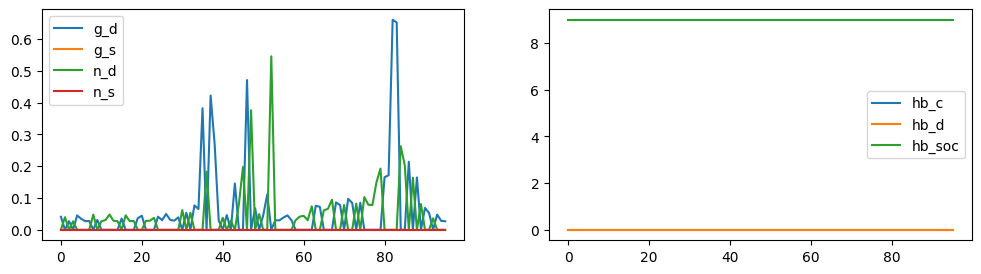

In [91]:
fig, ax = plt.subplots(figsize = (12,3), ncols=2)
ax[0].plot([m.getVars()[i + len(time_index)*0].X for i in range(t_max)], label = 'g_d')
ax[0].plot([m.getVars()[i + len(time_index)*1].X for i in range(t_max)], label = 'g_s')
ax[0].plot([m.getVars()[i + len(time_index)*4].X for i in range(t_max)], label = 'n_d')
ax[0].plot([m.getVars()[i + len(time_index)*5].X for i in range(t_max)], label = 'n_s')
ax[0].legend()
ax[1].plot([m.getVars()[i + len(time_index)*10].X for i in range(t_max)], label = 'hb_c')
ax[1].plot([m.getVars()[i + len(time_index)*11].X for i in range(t_max)], label = 'hb_d')
ax[1].plot([m.getVars()[i + len(time_index)*14].X for i in range(t_max)], label = 'hb_soc')
ax[1].legend()
plt.show()

In [22]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [92]:
m.getVars()

[<gurobi.Var g_demand[0] (value 0.040828626666666666)>,
 <gurobi.Var g_demand[1] (value 0.0)>,
 <gurobi.Var g_demand[2] (value 0.027022966666666665)>,
 <gurobi.Var g_demand[3] (value 0.0)>,
 <gurobi.Var g_demand[4] (value 0.045004300000000004)>,
 <gurobi.Var g_demand[5] (value 0.03461260000000001)>,
 <gurobi.Var g_demand[6] (value 0.027051750000000003)>,
 <gurobi.Var g_demand[7] (value 0.027536483333333337)>,
 <gurobi.Var g_demand[8] (value 0.0)>,
 <gurobi.Var g_demand[9] (value 0.0311074115)>,
 <gurobi.Var g_demand[10] (value 0.0)>,
 <gurobi.Var g_demand[11] (value 0.0)>,
 <gurobi.Var g_demand[12] (value 0.0)>,
 <gurobi.Var g_demand[13] (value 0.0)>,
 <gurobi.Var g_demand[14] (value 0.0)>,
 <gurobi.Var g_demand[15] (value 0.03520232833333334)>,
 <gurobi.Var g_demand[16] (value 0.0)>,
 <gurobi.Var g_demand[17] (value 0.0)>,
 <gurobi.Var g_demand[18] (value 0.0)>,
 <gurobi.Var g_demand[19] (value 0.03663821333333333)>,
 <gurobi.Var g_demand[20] (value 0.04412492333333333)>,
 <gurobi.Var

In [16]:
[m.getVars()[0 + len(time_index) * i] for i in range(15)]

[<gurobi.Var g_demand[0] (value 0.0)>,
 <gurobi.Var g_supply[0] (value 0.0)>,
 <gurobi.Var g_d_binary[0] (value 1.0)>,
 <gurobi.Var g_s_binary[0] (value 0.0)>,
 <gurobi.Var n_demand[0] (value 0.040828626666666666)>,
 <gurobi.Var n_supply[0] (value 0.0)>,
 <gurobi.Var n_d_binary[0] (value 1.0)>,
 <gurobi.Var n_s_binary[0] (value 0.0)>,
 <gurobi.Var pv_surplus[0] (value 0.0)>,
 <gurobi.Var pv[0] (value 0.0)>,
 <gurobi.Var hb_c[0] (value 0.0)>,
 <gurobi.Var hb_d[0] (value 0.0)>,
 <gurobi.Var hb_c_binary[0] (value 1.0)>,
 <gurobi.Var hb_d_binary[0] (value -0.0)>,
 <gurobi.Var hb_soc_t[0] (value 9.630128435729086)>]

In [18]:
# result tracking: only consider t[0] for each variable
price_g_d, price_g_s, = price_g_d[t], price_g_s[t]
price_n_d, price_n_s = price_n_d[t], price_n_s[t]
g_d, g_s, = m.getVars()[0 + len(time_index) * 0].X, m.getVars()[0 + len(time_index) * 1].X
n_d, n_s = m.getVars()[0 + len(time_index) * 4].X, m.getVars()[0 + len(time_index) * 5].X
PV_max, pv, = PV_max[t], m.getVars()[0 + len(time_index) * 9].X
pv_surplus_binary = m.getVars()[0 + len(time_index) * 8].X
hb_c, hb_d = m.getVars()[0 + len(time_index) * 10].X, m.getVars()[0 + len(time_index) * 11].X
hb_soc_t = m.getVars()[0 + len(time_index) * 14].X
D_bl, d_bl = D_bl[t], g_d - g_s + n_d - n_s + pv - hb_c + hb_d
costs_t = price_g_d * g_d - price_g_s * g_s + price_n_d * n_d - price_n_s * n_s + lcoe_pv * pv + \
               lcoe_hb * hb_c + lcoe_hb * hb_d
costs_total += costs_t
gp.disposeDefaultEnv()

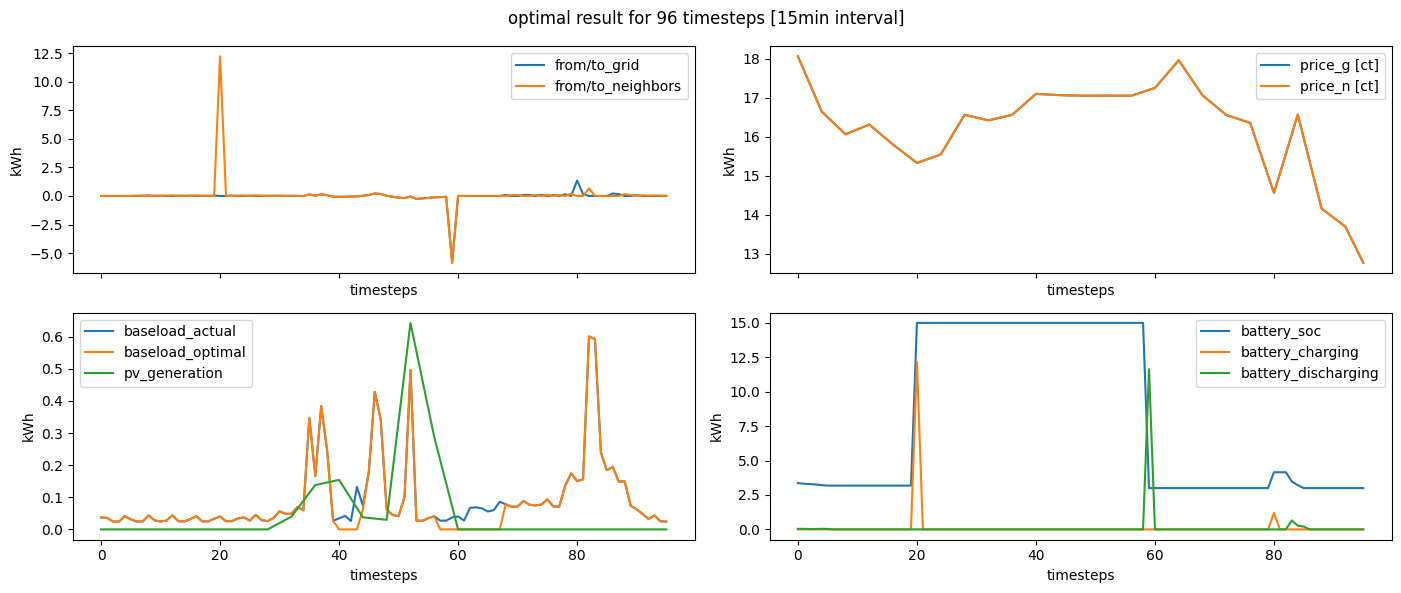

In [13]:
fig, axs = plt.subplots(figsize=(14, 6), ncols=2, nrows=2, sharex=True)
axs[0][0].plot([i.X for i in g.values()], label='from/to_grid')
axs[0][0].plot([i.X for i in n.values()], label='from/to_neighbors')

axs[0][1].plot([i for i in price_g], label='price_g [ct]')
axs[0][1].plot([i for i in price_n], label='price_n [ct]')

axs[1][0].plot([i for i in D_bl_max], label='baseload_actual')
axs[1][0].plot([i.X for i in d_bl.values()], label='baseload_optimal')
axs[1][0].plot([i.X for i in pv.values()], label='pv_generation')

axs[1][1].plot([i.X for i in hb_soc.values()], label='battery_soc')
axs[1][1].plot([i.X for i in hb_c.values()], label='battery_charging')
axs[1][1].plot([i.X for i in hb_d.values()], label='battery_discharging')

for col in axs:
    for row in col:
        row.legend()
        row.set_xlabel('timesteps')
        row.set_ylabel('kWh')
plt.suptitle(f'optimal result for {t_max} timesteps [15min interval]')
plt.tight_layout()
plt.show()